Epoch 1/200, Loss: 0.0243, Accuracy: 97.57%, F1 Score: 0.9877
Epoch 2/200, Loss: 0.0232, Accuracy: 97.54%, F1 Score: 0.9876
Epoch 3/200, Loss: 0.0197, Accuracy: 96.68%, F1 Score: 0.9831
Epoch 4/200, Loss: 0.0201, Accuracy: 96.26%, F1 Score: 0.9809
Epoch 5/200, Loss: 0.0198, Accuracy: 96.07%, F1 Score: 0.9799
Epoch 6/200, Loss: 0.0196, Accuracy: 96.09%, F1 Score: 0.9801
Epoch 7/200, Loss: 0.0197, Accuracy: 95.91%, F1 Score: 0.9791
Epoch 8/200, Loss: 0.0195, Accuracy: 95.88%, F1 Score: 0.9790
Epoch 9/200, Loss: 0.0197, Accuracy: 95.89%, F1 Score: 0.9790
Epoch 10/200, Loss: 0.0195, Accuracy: 95.80%, F1 Score: 0.9786
Epoch 11/200, Loss: 0.0194, Accuracy: 95.84%, F1 Score: 0.9788
Epoch 12/200, Loss: 0.0194, Accuracy: 95.74%, F1 Score: 0.9782
Epoch 13/200, Loss: 0.0193, Accuracy: 95.82%, F1 Score: 0.9786
Epoch 14/200, Loss: 0.0194, Accuracy: 95.78%, F1 Score: 0.9784
Epoch 15/200, Loss: 0.0194, Accuracy: 95.73%, F1 Score: 0.9782
Epoch 16/200, Loss: 0.0192, Accuracy: 95.79%, F1 Score: 0.9785
E

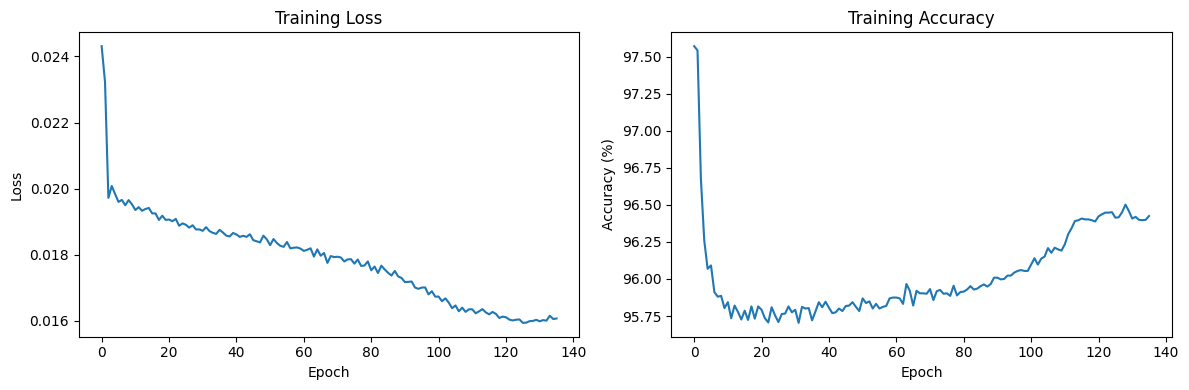

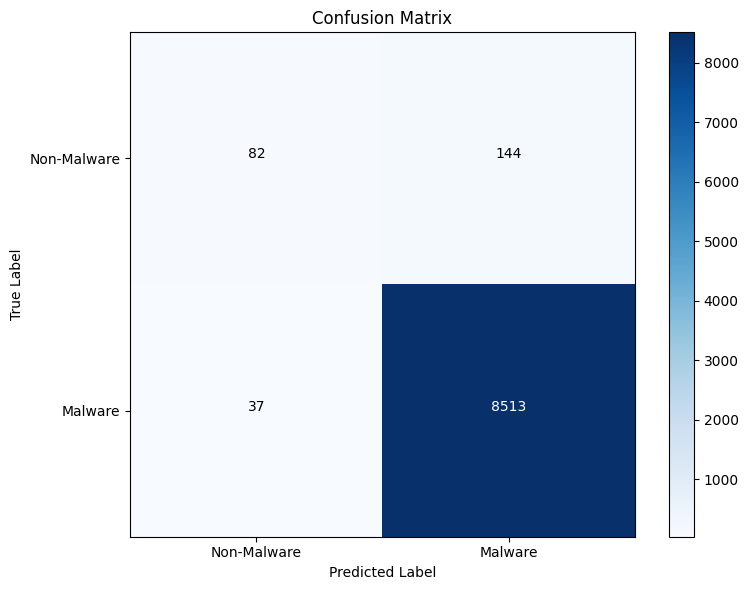

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def logistic(x):
    x = np.clip(x, -500, 500)  # Clipping the input to avoid overflow
    return 1.0 / (1 + np.exp(-x))

def logistic_deriv(x):
    return logistic(x) * (1 - logistic(x))

# Load and preprocess data
data = pd.read_csv('./content/dynamic_api_call_sequence_per_malware_100_0_306.csv')
X = data.drop(columns=['hash', 'malware']).values
y = data['malware'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters
LR = 0.01
I_dim = X.shape[1]
H_dim = 8
max_epochs = 200
batch_size = 32
early_stopping_patience = 10

# Initialize weights
np.random.seed(42)
weights_ItoH = np.random.uniform(-1, 1, (I_dim, H_dim)) / np.sqrt(I_dim)
weights_HtoO = np.random.uniform(-1, 1, H_dim) / np.sqrt(H_dim)

# Training
best_loss = float('inf')
patience_counter = 0
train_losses = []
train_accuracies = []

for epoch in range(max_epochs):
    # Shuffle data
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]

    total_loss = 0
    predictions = []
    for i in range(0, len(X_train), batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # Forward pass
        hidden = logistic(np.dot(X_batch, weights_ItoH))
        output = logistic(np.dot(hidden, weights_HtoO))

        # Compute loss
        loss = np.mean((output - y_batch) ** 2)
        total_loss += loss

        predictions.extend(output)

        # Backward pass
        delta_output = (output - y_batch) * logistic_deriv(output)
        delta_hidden = np.outer(delta_output, weights_HtoO) * logistic_deriv(hidden)

        # Update weights
        weights_HtoO -= LR * np.dot(hidden.T, delta_output)
        weights_ItoH -= LR * np.dot(X_batch.T, delta_hidden)

    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)

    # Calculate training accuracy and F1 score
    train_pred = (np.array(predictions) > 0.5).astype(int)
    train_accuracy = np.mean(train_pred == y_train) * 100
    train_f1 = f1_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%, F1 Score: {train_f1:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Validation on test set
test_hidden = logistic(np.dot(X_test, weights_ItoH))
test_output = logistic(np.dot(test_hidden, weights_HtoO))
test_pred = (test_output > 0.5).astype(int)

test_accuracy = np.mean(test_pred == y_test) * 100
test_f1 = f1_score(y_test, test_pred)

print(f'\nTest Accuracy: {test_accuracy:.2f}%')
print(f'Test F1 Score: {test_f1:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, test_pred))

# Visualizations
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Malware', 'Malware'])
plt.yticks(tick_marks, ['Non-Malware', 'Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()